# Define the system  

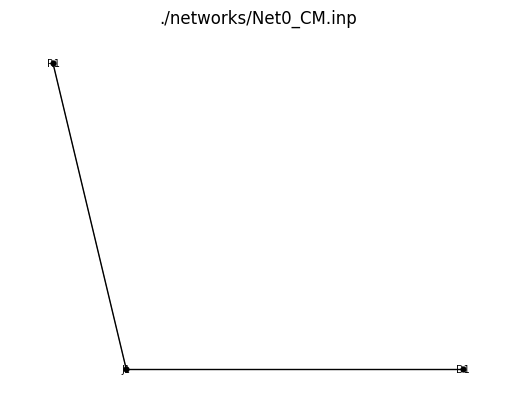

<Axes: title={'center': './networks/Net0_CM.inp'}>

In [1]:
import wntr
import wntr_quantum
import numpy as np

# Create a water network model
inp_file = './networks/Net0_CM.inp'
# inp_file = './networks/Net2LoopsDW.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)


## Run with the original Cholesky EPANET simulator

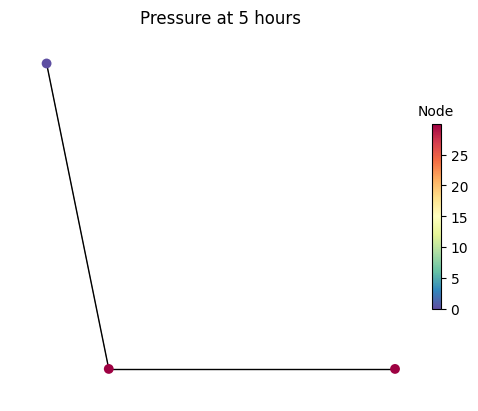

<Axes: title={'center': 'Pressure at 5 hours'}>

In [2]:
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()
# Plot results on the network
pressure_at_5hr = results.node['pressure'].loc[0, :]
wntr.graphics.plot_network(wn, node_attribute=pressure_at_5hr, node_size=50,
                        title='Pressure at 5 hours', node_labels=False)

In [3]:
ref_pressure = results.node['pressure'].values[0][:2]
ref_pressure

array([29.994, 29.988], dtype=float32)

In [4]:
ref_rate = results.link['flowrate'].values[0]
ref_rate

array([0.05, 0.05], dtype=float32)

In [5]:
ref_values = np.append(ref_rate, ref_pressure)
ref_values

array([ 0.05 ,  0.05 , 29.994, 29.988], dtype=float32)

# Run with the Custom EPANET simulator

/home/nico/QuantumApplicationLab/vitens/wntr-quantum/wntr_quantum/epanet/Linux/libepanet22_amd64.so
Roughness : 0.015000
Diameter  : 3.280840
Length    : 3280.839895
CM Coeff  : 0.006059

Roughness : 0.015000
Diameter  : 3.280840
Length    : 3280.839895
CM Coeff  : 0.006059

Reservoir : 98.425197
Reservoir : 98.425197
Reservoir : 98.425197


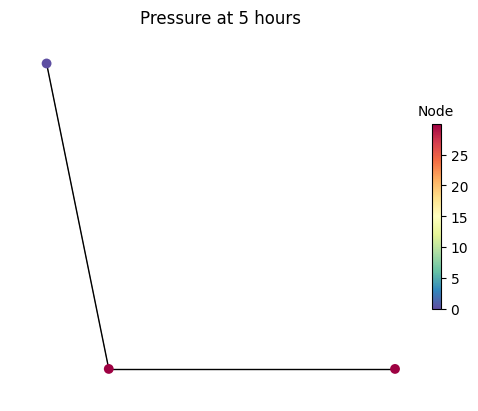

<Axes: title={'center': 'Pressure at 5 hours'}>

In [6]:
import os 
os.environ["EPANET_TMP"] = "/home/nico/.epanet_quantum"
os.environ["EPANET_QUANTUM"] = "/home/nico/QuantumApplicationLab/vitens/EPANET"
sim = wntr_quantum.sim.QuantumEpanetSimulator(wn)
results = sim.run_sim()
# Plot results on the network
pressure_at_5hr = results.node['pressure'].loc[0, :]
wntr.graphics.plot_network(wn, node_attribute=pressure_at_5hr, node_size=50,
                        title='Pressure at 5 hours', node_labels=False)

## Run with the Nework QUBO solver

In [7]:
wn = wntr.network.WaterNetworkModel(inp_file)

In [8]:
from wntr_quantum.sim.solvers.qubo_polynomial_solver import QuboPolynomialSolver
from qubols.solution_vector import SolutionVector_V2 as SolutionVector
from qubols.encodings import  RangedEfficientEncoding, PositiveQbitEncoding

nqbit = 9
step = (0.5/(2**nqbit-1))
flow_encoding = PositiveQbitEncoding(nqbit=nqbit, step=step, offset=+1.5, var_base_name="x")

nqbit = 9
step = (50/(2**nqbit-1))
head_encoding = PositiveQbitEncoding(nqbit=nqbit, step=step, offset=+50.0, var_base_name="x")

net = QuboPolynomialSolver(wn, flow_encoding=flow_encoding, 
              head_encoding=head_encoding)
net.verify_encoding()

Head Encoding : 50.000000 => 100.000000 (res: 0.097847)
Flow Encoding : 1.500000 => 2.000000 (res: 0.000978)


Solve the system classically

In [9]:
from wntr_quantum.sim.hydraulics import create_hydraulic_model
model, model_updater = create_hydraulic_model(wn)
net.matrices = net.initialize_matrices(model)

ref_sol = net.classical_solutions()
ref_sol / ref_values

/home/nico/QuantumApplicationLab/QuantumNewtonRaphson/quantum_newton_raphson/utils.py:74: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn("spsolve requires A be CSC or CSR matrix format", SparseEfficiencyWarning)


array([1., 1., 1., 1.])

In [10]:
from qubols.mixed_solution_vector import MixedSolutionVector_V2 as MixedSolutionVector
from qubols.qubo_poly_mixed_variables import QUBO_POLY_MIXED
from qubols.solution_vector import SolutionVector_V2 as SolutionVector
import sparse

from dwave.samplers import SimulatedAnnealingSampler
from dwave.samplers import SteepestDescentSolver
from dwave.samplers import TabuSampler
from dimod import ExactSolver

from wntr_quantum.sim.hydraulics import create_hydraulic_model

sampler = TabuSampler()
sampler = SteepestDescentSolver()
# sampler = SimulatedAnnealingSampler()
# sampler = ExactSolver() 

model, model_updater = create_hydraulic_model(wn)
net.matrices = net.initialize_matrices(model)

qubo = QUBO_POLY_MIXED(net.mixed_solution_vector,  options={"sampler" : sampler} )
matrices = tuple(sparse.COO(m) for m in net.matrices)
bqm = qubo.create_bqm(matrices, strength=1E6)
sampleset = qubo.sample_bqm(bqm, num_reads=10000)
sol = qubo.decode_solution(sampleset.lowest().record[0][0])
sol = net.flatten_solution_vector(sol)


In [11]:
sol = net.convert_solution_to_si(sol)

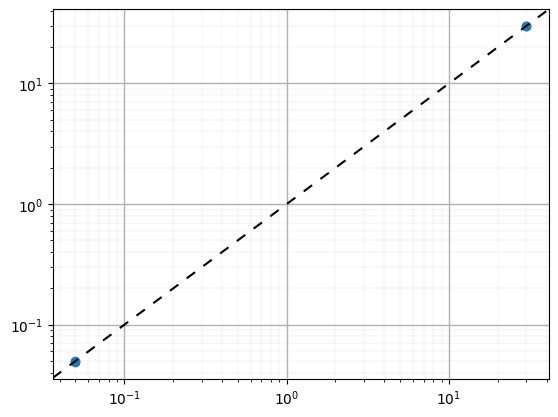

In [12]:
net.plot_solution_vs_reference(sol, ref_sol)

In [13]:
net.diagnostic_solution(sol, ref_sol, qubo, bqm)

Head Encoding : 50.000000 => 100.000000 (res: 0.097847)
Flow Encoding : 1.500000 => 2.000000 (res: 0.000978)


Error (%): [ 1.584  0.808 -0.128 -0.048]


sol :  [ 1.738  1.751 98.532 98.434]
ref :  [ 1.766  1.766 98.406 98.387]
diff:  [ 0.028  0.014 -0.126 -0.047]


encoded_sol:  [ 1.738  1.751 98.532 98.434]
encoded_ref:  [ 1.766  1.766 98.434 98.434]
diff       :  [ 0.028  0.015 -0.098  0.   ]


E sol   :  -2343.728691322684
R ref   :  -2343.749937932273
Delta E : 0.02124660958907043


Residue sol   :  0.14964997001021535
Residue ref   :  0.03388956865892264
Delta Residue : 0.1157604013512927


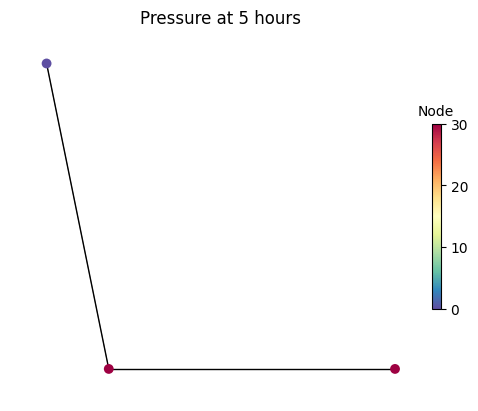

<Axes: title={'center': 'Pressure at 5 hours'}>

In [16]:
sim = wntr_quantum.sim.FullQuboPolynomialSimulator(wn, 
                                                   flow_encoding=flow_encoding, 
                                                   head_encoding=head_encoding)
results = sim.run_sim(solver_options={"sampler" : sampler})

# Plot results on the network
pressure_at_5hr = results.node['pressure'].loc[0, :]
wntr.graphics.plot_network(wn, node_attribute=pressure_at_5hr, node_size=50,
                        title='Pressure at 5 hours', node_labels=False)